In [1]:
! wget -N https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/sarcasm/train-balanced-sarcasm.csv -P /tmp

--2019-09-16 22:15:49--  https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/sarcasm/train-balanced-sarcasm.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.179.61
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.179.61|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File '/tmp/train-balanced-sarcasm.csv' not modified on server. Omitting download.



In [1]:
import os
import sys
import time
import warnings

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import numpy as np
import pandas as pd

from pyspark.sql import SparkSession
packages = [
    'JohnSnowLabs:spark-nlp:2.3.4'
]
spark = SparkSession \
    .builder \
    .appName("ML SQL session") \
    .config('spark.jars.packages', ','.join(packages)) \
    .config("spark.driver.memory","16g") \
    .getOrCreate()

In [2]:
import sparknlp

print("Spark NLP version: ", sparknlp.version())
print("Apache Spark version: ", spark.version)

Spark NLP version:  2.3.4
Apache Spark version:  2.4.4


In [4]:
from pyspark.sql import SQLContext

sql = SQLContext(spark)

trainBalancedSarcasmDF = spark.read.option("header", True).option("inferSchema", True) \
    .csv("/tmp/train-balanced-sarcasm.csv")
trainBalancedSarcasmDF.printSchema()

# Let's create a temp view (table) for our SQL queries
trainBalancedSarcasmDF.createOrReplaceTempView('sarcasm')

sql.sql('SELECT COUNT(*) FROM sarcasm').collect()

root
 |-- label: integer (nullable = true)
 |-- comment: string (nullable = true)
 |-- author: string (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- score: string (nullable = true)
 |-- ups: string (nullable = true)
 |-- downs: string (nullable = true)
 |-- date: string (nullable = true)
 |-- created_utc: string (nullable = true)
 |-- parent_comment: string (nullable = true)



[Row(count(1)=1010826)]

In [5]:
df = sql.sql('''
select label, concat(parent_comment,"\n",comment) as comment 
from sarcasm 
where comment is not null and parent_comment is not null limit 100000''')
print(type(df))
df.printSchema()
print('rows', df.count())
df.show()

<class 'pyspark.sql.dataframe.DataFrame'>
root
 |-- label: integer (nullable = true)
 |-- comment: string (nullable = true)

rows 100000
+-----+--------------------+
|label|             comment|
+-----+--------------------+
|    0|Yeah, I get that ...|
|    0|The blazers and M...|
|    0|They're favored t...|
|    0|deadass don't kil...|
|    0|Yep can confirm I...|
|    0|do you find arian...|
|    0|What's your weird...|
|    0|Probably Sephirot...|
|    0|What to upgrade? ...|
|    0|Probably count Ka...|
|    0|I bet if that mon...|
|    0|James Shields Wil...|
|    0|There's no time t...|
|    0|Team Specific Thr...|
|    0|Ill give you a hi...|
|    0|Star Wars, easy. ...|
|    0|You're adorable.
...|
|    0|He actually acts ...|
|    0|Clinton struggles...|
|    0|Is that the Older...|
+-----+--------------------+
only showing top 20 rows



In [6]:
from sparknlp.annotator import *
from sparknlp.common import *
from sparknlp.base import *

from pyspark.ml import Pipeline

document_assembler = DocumentAssembler() \
    .setInputCol("comment") \
    .setOutputCol("document")
    
sentence_detector = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentence") \
    .setUseAbbreviations(True)
    
tokenizer = Tokenizer() \
  .setInputCols(["sentence"]) \
  .setOutputCol("token")

nlp_pipeline = Pipeline(stages=[document_assembler, sentence_detector, tokenizer])
nlp_model = nlp_pipeline.fit(df)

processed = nlp_model.transform(df)
processed.show()

train, test = processed.randomSplit(weights=[0.7, 0.3], seed=123)

print(train.count())
print(test.count())

+-----+--------------------+--------------------+--------------------+--------------------+
|label|             comment|            document|            sentence|               token|
+-----+--------------------+--------------------+--------------------+--------------------+
|    0|Yeah, I get that ...|[[document, 0, 90...|[[document, 0, 25...|[[token, 0, 3, Ye...|
|    0|The blazers and M...|[[document, 0, 20...|[[document, 0, 13...|[[token, 0, 2, Th...|
|    0|They're favored t...|[[document, 0, 14...|[[document, 0, 22...|[[token, 0, 6, Th...|
|    0|deadass don't kil...|[[document, 0, 90...|[[document, 0, 90...|[[token, 0, 6, de...|
|    0|Yep can confirm I...|[[document, 0, 11...|[[document, 0, 48...|[[token, 0, 2, Ye...|
|    0|do you find arian...|[[document, 0, 14...|[[document, 0, 14...|[[token, 0, 1, do...|
|    0|What's your weird...|[[document, 0, 98...|[[document, 0, 52...|[[token, 0, 5, Wh...|
|    0|Probably Sephirot...|[[document, 0, 14...|[[document, 0, 18...|[[token, 0

In [7]:
glove = WordEmbeddingsModel.pretrained()
train_featurized = glove.transform(train)
train_featurized.show()

glove_100d download started this may take some time.
Approximate size to download 144.3 MB
[OK!]
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|label|             comment|            document|            sentence|               token|          embeddings|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|    0|              !
Goes|[[document, 0, 5,...|[[document, 0, 5,...|[[token, 0, 0, !,...|[[word_embeddings...|
|    0|!completed
!compl...|[[document, 0, 20...|[[document, 0, 20...|[[token, 0, 0, !,...|[[word_embeddings...|
|    0|""" ""Very Right ...|[[document, 0, 10...|[[document, 0, 10...|[[token, 0, 2, ""...|[[word_embeddings...|
|    0|""" Perhaps you n...|[[document, 0, 61...|[[document, 0, 46...|[[token, 0, 2, ""...|[[word_embeddings...|
|    0|""" This covering...|[[document, 0, 33...|[[document, 0, 84...|[[token, 0, 2, ""...|[[word_embeddings...|

In [8]:
test_featurized = glove.transform(test)
test_featurized.show()

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|label|             comment|            document|            sentence|               token|          embeddings|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|    0|!RemindMe 1 week
...|[[document, 0, 32...|[[document, 0, 32...|[[token, 0, 0, !,...|[[word_embeddings...|
|    0|!Remindme 2 weeks...|[[document, 0, 34...|[[document, 0, 34...|[[token, 0, 0, !,...|[[word_embeddings...|
|    0|!SH!TPOST!: All t...|[[document, 0, 80...|[[document, 0, 79...|[[token, 0, 0, !,...|[[word_embeddings...|
|    0|"""**FUCK** Cloud...|[[document, 0, 54...|[[document, 0, 54...|[[token, 0, 4, ""...|[[word_embeddings...|
|    0|"""*Komrad
"*""Th...|[[document, 0, 56...|[[document, 0, 56...|[[token, 0, 3, ""...|[[word_embeddings...|
|    0|"""... thanks to ...|[[document, 0, 16...|[[document, 0, 16...|[[token, 0, 5, ""...|[[wor

In [9]:
def get_features(row):
    result = []
    for tk in row:
        result.append(tk['embeddings'])
    return np.array(result)

def build_data(df, chunks=10):
    x_train = []
    y_train = []

    row_count = df.count()
    i = 0
    
    chunks = df.randomSplit(weights=[1/chunks] * chunks)

    for chunk in chunks:
        rows = chunk.collect()
        for row in rows:
            if i % 1000 == 0:
                print('row {} / {} ({:.1f} %)'.format(i, row_count, 100 * i / row_count))
            embeddings = get_features(row['embeddings'])
            label = row['label']
            x_train.append(embeddings)
            y_train.append(label)
            i += 1

    x_train = np.array(x_train)
    y_train = np.array(y_train)
    return x_train, y_train

In [10]:
x_train, y_train = build_data(train_featurized)

row 0 / 70136 (0.0 %)
row 1000 / 70136 (1.4 %)
row 2000 / 70136 (2.9 %)
row 3000 / 70136 (4.3 %)
row 4000 / 70136 (5.7 %)
row 5000 / 70136 (7.1 %)
row 6000 / 70136 (8.6 %)
row 7000 / 70136 (10.0 %)
row 8000 / 70136 (11.4 %)
row 9000 / 70136 (12.8 %)
row 10000 / 70136 (14.3 %)
row 11000 / 70136 (15.7 %)
row 12000 / 70136 (17.1 %)
row 13000 / 70136 (18.5 %)
row 14000 / 70136 (20.0 %)
row 15000 / 70136 (21.4 %)
row 16000 / 70136 (22.8 %)
row 17000 / 70136 (24.2 %)
row 18000 / 70136 (25.7 %)
row 19000 / 70136 (27.1 %)
row 20000 / 70136 (28.5 %)
row 21000 / 70136 (29.9 %)
row 22000 / 70136 (31.4 %)
row 23000 / 70136 (32.8 %)
row 24000 / 70136 (34.2 %)
row 25000 / 70136 (35.6 %)
row 26000 / 70136 (37.1 %)
row 27000 / 70136 (38.5 %)
row 28000 / 70136 (39.9 %)
row 29000 / 70136 (41.3 %)
row 30000 / 70136 (42.8 %)
row 31000 / 70136 (44.2 %)
row 32000 / 70136 (45.6 %)
row 33000 / 70136 (47.1 %)
row 34000 / 70136 (48.5 %)
row 35000 / 70136 (49.9 %)
row 36000 / 70136 (51.3 %)
row 37000 / 70136 (52

In [11]:
x_test, y_test = build_data(test_featurized)

row 0 / 29864 (0.0 %)
row 1000 / 29864 (3.3 %)
row 2000 / 29864 (6.7 %)
row 3000 / 29864 (10.0 %)
row 4000 / 29864 (13.4 %)
row 5000 / 29864 (16.7 %)
row 6000 / 29864 (20.1 %)
row 7000 / 29864 (23.4 %)
row 8000 / 29864 (26.8 %)
row 9000 / 29864 (30.1 %)
row 10000 / 29864 (33.5 %)
row 11000 / 29864 (36.8 %)
row 12000 / 29864 (40.2 %)
row 13000 / 29864 (43.5 %)
row 14000 / 29864 (46.9 %)
row 15000 / 29864 (50.2 %)
row 16000 / 29864 (53.6 %)
row 17000 / 29864 (56.9 %)
row 18000 / 29864 (60.3 %)
row 19000 / 29864 (63.6 %)
row 20000 / 29864 (67.0 %)
row 21000 / 29864 (70.3 %)
row 22000 / 29864 (73.7 %)
row 23000 / 29864 (77.0 %)
row 24000 / 29864 (80.4 %)
row 25000 / 29864 (83.7 %)
row 26000 / 29864 (87.1 %)
row 27000 / 29864 (90.4 %)
row 28000 / 29864 (93.8 %)
row 29000 / 29864 (97.1 %)


In [12]:
spark.stop()

In [13]:
print('Train Labels:\n', pd.Series(y_train).value_counts())
print('Test Labels:\n', pd.Series(y_test).value_counts())

Train Labels:
 0    40466
1    29670
dtype: int64
Test Labels:
 0    17224
1    12640
dtype: int64


In [14]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D

# set parameters for our model:
maxlen = 100 #max 50 words per article
batch_size = 32 #size of the batch 
filters = 50 #dimension of filters for the convolutional layer
kernel_size = 3 #size of the kernel used in the convolutional layer
hidden_dims = 250 #dimension of the hidden layer
epochs = 5 #number of training epochs

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

Using TensorFlow backend.


In [15]:
print('Build model...')
model = Sequential()

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.add(Activation('sigmoid'))

from keras import backend as K


model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','mae'])

Build model...




In [16]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 70136 samples, validate on 29864 samples
Epoch 1/5
70136/70136 [==============================] - 11s 154us/step - loss: 0.6560 - acc: 0.6187 - mean_absolute_error: 0.4626 - val_loss: 0.6500 - val_acc: 0.6231 - val_mean_absolute_error: 0.4633
Epoch 2/5
70136/70136 [==============================] - 11s 151us/step - loss: 0.6307 - acc: 0.6469 - mean_absolute_error: 0.4401 - val_loss: 0.6452 - val_acc: 0.6276 - val_mean_absolute_error: 0.4526
Epoch 3/5
70136/70136 [==============================] - 11s 150us/step - loss: 0.6105 - acc: 0.6675 - mean_absolute_error: 0.4222 - val_loss: 0.6419 - val_acc: 0.6356 - val_mean_absolute_error: 0.4418
Epoch 4/5
70136/70136 [==============================] - 11s 151us/step - loss: 0.5913 - acc: 0.6866 - mean_absolute_error: 0.4059 

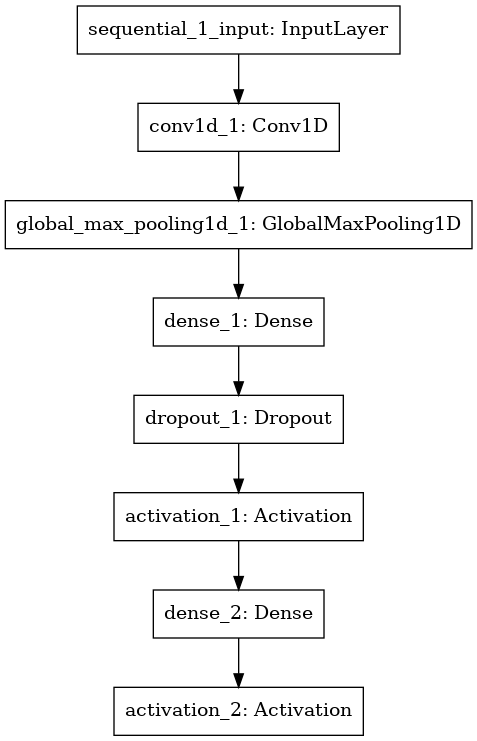

In [17]:
from IPython.display import Image
from keras.utils.vis_utils import model_to_dot
dot = model_to_dot(model)
Image(dot.create_png())